<a href="https://colab.research.google.com/github/SourLemon23/covid19-diagnosis/blob/master/COVID_19_CT_Diagnosis_V13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

import tensorflow.keras.backend as K
from tensorflow import GradientTape

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import scipy
print('Using SciPy Version:', scipy.__version__) # Should be 1.1.0

import os
import csv
from pathlib import Path
from PIL import Image
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import datetime
import random

# EfficientNetB7
! pip install -U efficientnet
from efficientnet.tfkeras import EfficientNetB7, preprocess_input

Using TensorFlow Version: 2.4.0
Using SciPy Version: 1.4.1
     |████████████████████████████████| 51kB 7.0MB/s 


In [2]:
# Check if the hardware accelerator is set to GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Initialize dataset directories (Google Drive)
training_dir   = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V9/Training'
validation_dir = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V9/Validation'
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V9/Testing'

In [5]:
# Saved weights and model
checkpoint_filepath = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/weights.h5'
model_filepath = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/model'

In [6]:
# Tensorboard logs
logs = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/logs'

In [7]:
# Initialize constants
CLASSES = ['COVID-19 Positive', 'COVID-19 Negative']

# Need 3 grayscale channels to be compatible w/ imagenet weights (RGB)
CHANNELS = 3
COLOR_MODE = 'rgb'

IMG_WIDTH, IMG_HEIGHT = 224, 224
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 30

METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall')]

COVID_THRESHOLD = 0.3
THRESHOLD_VALUE = 0.5
NORMAL_THRESHOLD = 0.7

PERCENTAGE_FACTOR = 100;

font_settings = {'family': 'DejaVu Sans',
                  'color' : 'red',
                  'weight': 'heavy',
                  'size'  :  11}

**Data Preprocessing**

In [8]:
def load_data(dir):
    img_paths = []

    for root, dirs, files in os.walk(dir):
        for filename in files:
            abs_path = os.path.abspath(os.path.join(root, filename))
            img_paths.append(abs_path)

    return img_paths

In [9]:
def extract_slices(orig_slices_dir, lesion_slices_file):
    orig_paths = []
    for root, dirs, files in os.walk(orig_slices_dir):
        for filename in files:
            abs_path = os.path.abspath(os.path.join(root, filename))
            orig_paths.append(abs_path)

    with open(lesion_slices_file, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)

        lesion_paths = []
        for line in csv_reader:
        	  # Replace with the parent directory your original slices are located in
            path_dir = ''
            abs_path = path_dir + line[0].replace('/', '\\')

            lesion_paths.append(abs_path)

    csv_file.close()

    for img_path in orig_paths:
        if img_path not in lesion_paths:
            os.remove(img_path)

In [10]:
# Crop the image along the contours
def lungs_region_auto_crop(img_path=None, img_array=None, plot=False):
    if img_path is not None:
        img = cv2.imread(img_path)
        img2 = img.copy()
    else:
        img = img_array
        img2 = img_array.copy()

    grayscale_img = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    smoothed_img = cv2.GaussianBlur(grayscale_img, (5, 5), 0)

    binary_img = cv2.threshold(smoothed_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    kernel = np.ones((8, 8), dtype=np.uint8)
    eroded_img = cv2.erode(binary_img, kernel, iterations=1)
    dilated_img = cv2.dilate(eroded_img, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(dilated_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(contour) for contour in contours]

    max_index = np.argmax(areas)
    contour = contours[max_index]
    cv2.drawContours(img2, contours, -1, (0, 255, 0), 3)

    x, y, w, h = cv2.boundingRect(contour)
    xmin = x
    xmax = x + w
    ymin = y
    ymax = y + h
    cv2.rectangle(img2, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    cropped_img = img[ymin:ymax, xmin:xmax]

    if plot:
        fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(24, 4), constrained_layout=True)
        
        for i, img_filter in enumerate(['Grayscale', 'Smoothed', 'Binary', 'Eroded', 'Dilated', 'Contoured', 'Cropped']):
            axs[i].set_title(img_filter)

        axs[0].imshow(grayscale_img)
        axs[1].imshow(smoothed_img)
        axs[2].imshow(binary_img)
        axs[3].imshow(eroded_img)
        axs[4].imshow(dilated_img)
        axs[5].imshow(img2)
        axs[6].imshow(cropped_img)

        plt.show()

    return cropped_img

In [11]:
def process_data(file_paths, crop=False):
    processed_png_imgs = []

    for img_path in file_paths:
        if crop:
            cropped_img = lungs_region_auto_crop(img_path=img_path)
            processed_png_imgs.append(cropped_img)
        else:
            img = cv2.imread(img_path)
            processed_png_imgs.append(img)

    return processed_png_imgs

In [12]:
def write_imgs(img_paths, processed_imgs, new_dir):
    for i, img_path in enumerate(img_paths):
        # print('img_path:', img_path)
        path_after_dir = r'/'.join(Path(img_path).parts[7:])
        # print('path_after_dir:', path_after_dir)
        final_img_path = Path(os.path.join(new_dir, path_after_dir))
        # print('final_img_path:', final_img_path)
        final_img_dir = final_img_path.parent
        # print('final_img_dir:', final_img_dir)

        if os.path.isdir(str(final_img_dir)) == False:
            os.makedirs(final_img_dir)
            print('New directory made:', final_img_dir)
          
        cv2.imwrite(str(final_img_path), processed_imgs[i])

In [13]:
# # Crop all images within a directory
# dir = r''
# new_dir = r''

# img_paths = load_data(dir)
# print('# img paths:', len(img_paths))

# processed_imgs = process_data(img_paths, crop=True)
# print('# imgs processed:', len(processed_imgs))

# write_imgs(img_paths, processed_imgs, new_dir)

In [14]:
# Plot a batch of images with their labels
def visualize_data(data_generator):
    batch = data_generator.next()
    image_batch = batch[0]
    batch_labels = batch[1]

    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(24, 14), constrained_layout=True)
    batch_length = len(image_batch)

    for i, image in enumerate(image_batch):
        if int(batch_labels[i]) == 0:
            title = 'COVID-19'
            font_settings.update({'color': 'red'})
        elif int(batch_labels[i]) == 1:
            title = 'Normal'
            font_settings.update({'color': 'blue'})

        if i < (1 / 4) * batch_length:
            axs[0, i].imshow(image_batch[i])
            axs[0, i].set_title(title, fontdict=font_settings)
        elif i < (2 / 4) * batch_length:
            axs[1, i - 8].imshow(image_batch[i])
            axs[1, i - 8].set_title(title, fontdict=font_settings)
        elif i < (3 / 4) * batch_length:
            axs[2, i - 16].imshow(image_batch[i])
            axs[2, i - 16].set_title(title, fontdict=font_settings)
        else:
            axs[3, i - 24].imshow(image_batch[i])
            axs[3, i - 24].set_title(title, fontdict=font_settings)

    plt.show()

In [15]:
# Augment data
training_data_gen = ImageDataGenerator(rescale=1./255,              # Simplify pixel values to be 0-1
                                       horizontal_flip=True,        # Randomly flip images horizontally
                                       zoom_range=0.1,              # Randomly zoom
                                       shear_range=0.1,             # Shear angle in counter-clockwise direction
                                       rotation_range=10,           # Randomly rotate
                                       width_shift_range=0.05,      # Randomly shift the image left/right
                                       height_shift_range=0.05,     # Randomly shift the image up/down
                                       fill_mode='constant',        # Filling mode for points outside boundaries
                                       cval=60,                     # Value used for points outside the boundaries
                                       brightness_range=(0.8, 1.2)) # Randomly adjust the brightness

validation_data_gen = ImageDataGenerator(rescale=1./255)

In [16]:
# Split data
training_generator = training_data_gen.flow_from_directory(training_dir,
                                                           color_mode=COLOR_MODE,
                                                           target_size=TARGET_SIZE,
                                                           class_mode='binary',
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               color_mode=COLOR_MODE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode='binary',
                                                               batch_size=BATCH_SIZE,
                                                               shuffle=True)

Found 14159 images belonging to 2 classes.
Found 1755 images belonging to 2 classes.


Training Batch:


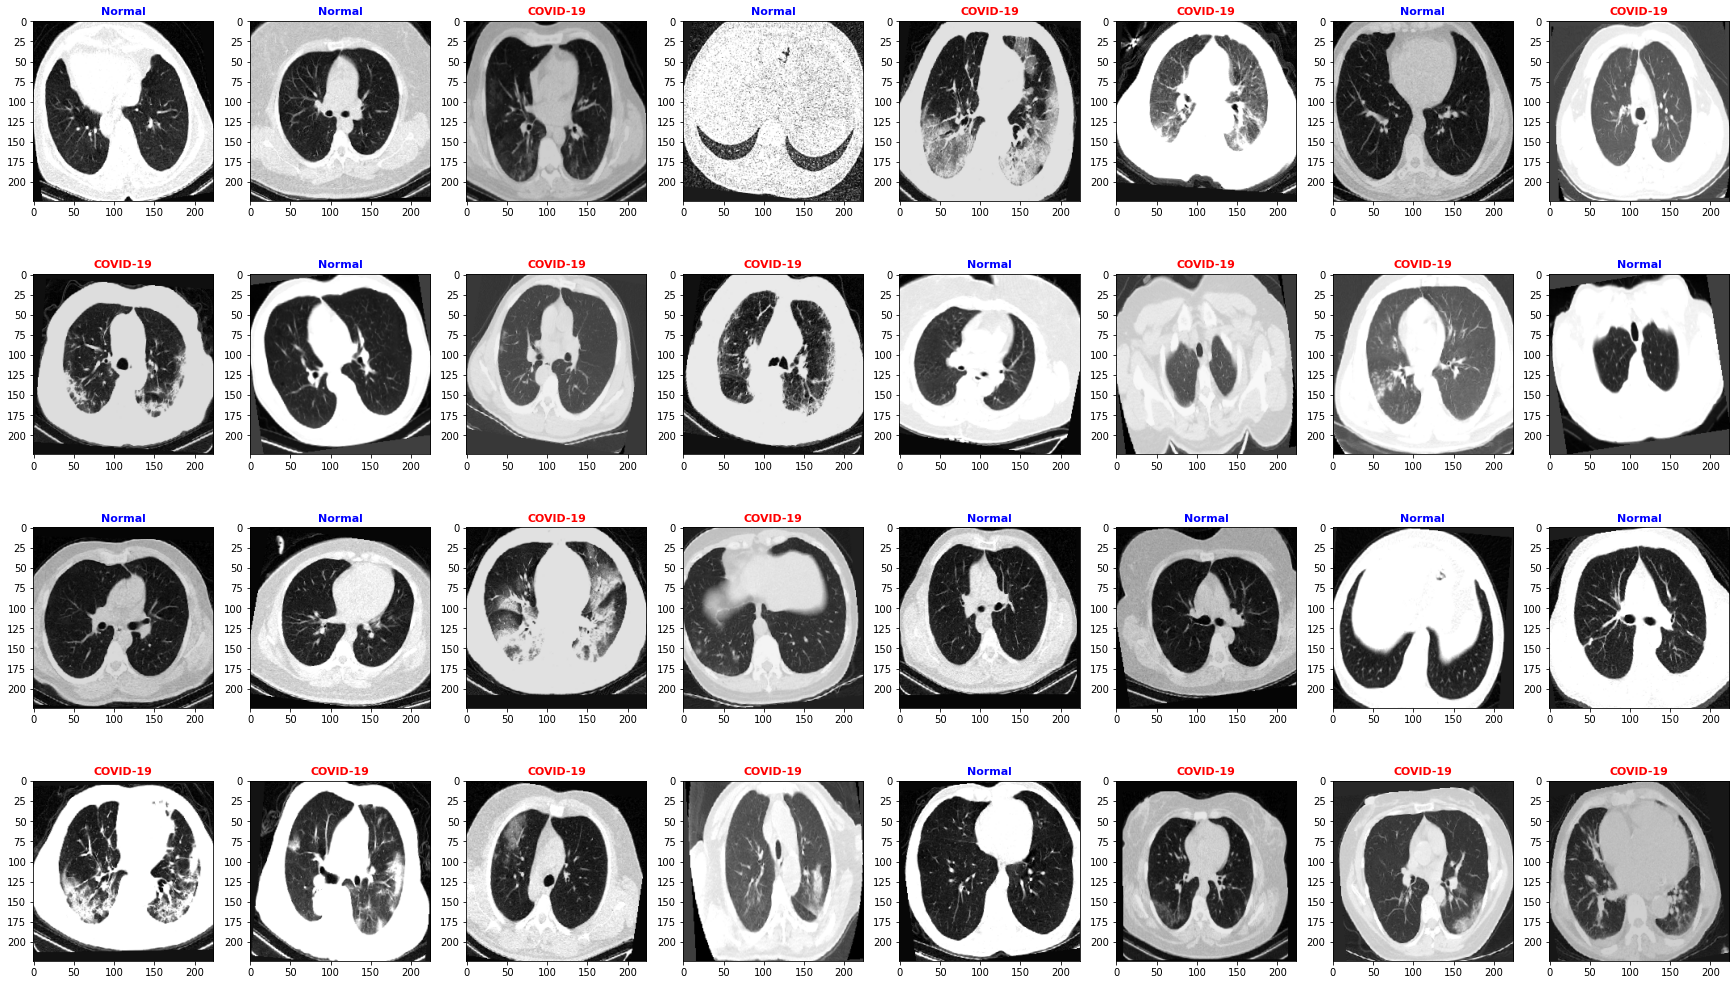




Validation Batch:


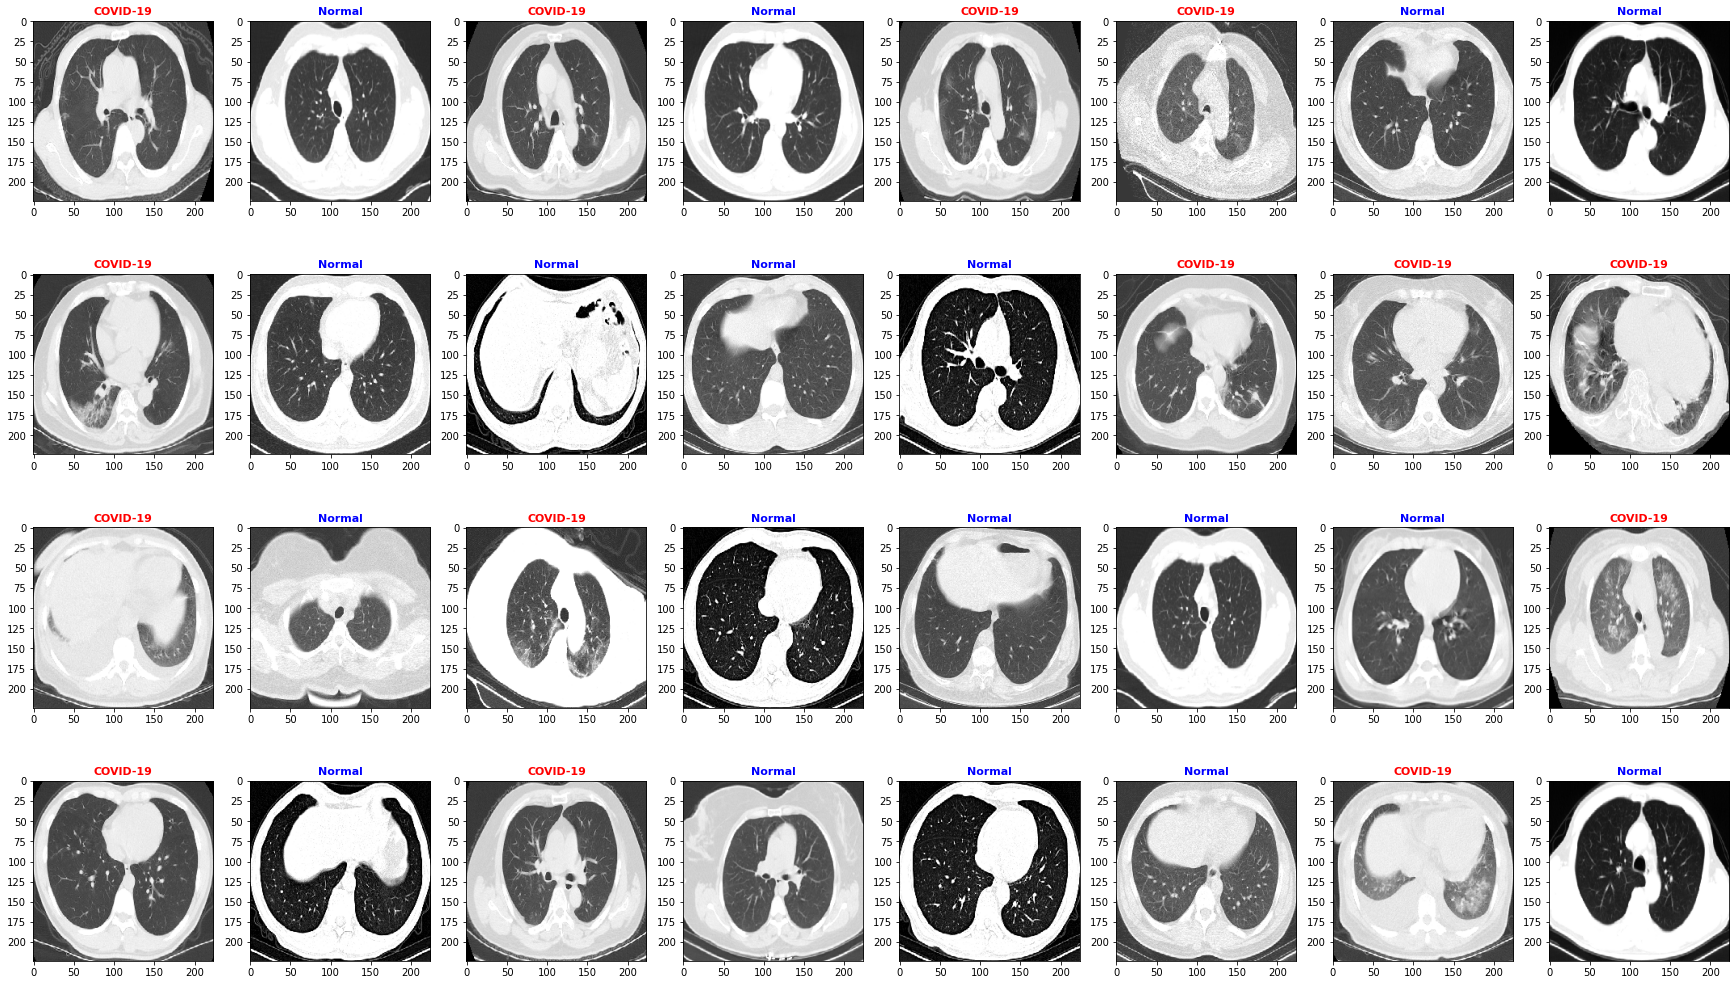

In [17]:
print('Training Batch:')
visualize_data(training_generator)
print('\n\n\nValidation Batch:')
visualize_data(validation_generator)

**Building the Model**

In [18]:
# Create a neural network
def create_model(print_summary=False):
    # Instantiate a base model with pre-trained weights
    base_model = EfficientNetB7(weights='imagenet',
                                include_top=False,
                                input_shape=INPUT_SHAPE)
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output

    # Add new classifier layers to the end of the base model
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    # x = Dense(1024, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)

    # A final dense layer with a single neuron (binary classification)
    predictions = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.inputs, outputs=predictions)

    if print_summary:
        model.summary()

    return model

In [19]:
# Configure model
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=LEARNING_RATE),
                  metrics=METRICS)

In [20]:
# Train the model
def fit_model(model):
    checkpoint_cb = ModelCheckpoint(checkpoint_filepath,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

    early_stopping_cb = EarlyStopping(monitor='val_loss',
                                      # min_delta=1e-3, # Original
                                      min_delta=1e-4,
                                      patience=5,
                                      mode='min',
                                      restore_best_weights=True)
    
    log_dir = logs + r'/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_cb = TensorBoard(log_dir=log_dir,
                                 histogram_freq=1)
    
    callbacks = [checkpoint_cb, early_stopping_cb, tensorboard_cb]

    history = model.fit(training_generator,
                        epochs=EPOCHS,
                        steps_per_epoch=(training_generator.n/BATCH_SIZE),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/BATCH_SIZE),
                        callbacks=callbacks)
    
    # Update weights that may have been further optimized during training
    model.load_weights(checkpoint_filepath)
    
    return history

In [21]:
# Visualize metrics with graphs
def evaluate_model(history):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(30, 4), constrained_layout=True)

    for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall']):
        if ('loss' in metric) is False:
            print('Best Training ' + metric.capitalize() + ':', str(max(history.history[metric]) * 100)[:5] + '%')
            print('Best Validation ' + metric.capitalize() + ':', str(max(history.history['val_' + metric]) * 100)[:5] + '%')
        else:
            print('Best Training ' + metric.capitalize() + ':', str(min(history.history[metric]))[:5])
            print('Best Validation ' + metric.capitalize() + ':', str(min(history.history['val_' + metric]))[:5])
        
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].set_title('Model {}'.format(metric.capitalize()))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend(['Training', 'Validation'])

In [22]:
# model = load_model(model_filepath)

In [23]:
model = create_model(print_summary=True)
compile_model(model)

258441216/258434480 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
___________________________

In [ ]:
history = fit_model(model)

Epoch 1/30
442/442 [==============================] - 3811s 9s/step - loss: 0.5932 - accuracy: 0.7059 - precision: 0.6976 - recall: 0.7413 - val_loss: 0.3297 - val_accuracy: 0.8519 - val_precision: 0.7947 - val_recall: 0.9487
Epoch 2/30
442/442 [==============================] - 343s 774ms/step - loss: 0.4045 - accuracy: 0.8144 - precision: 0.7990 - recall: 0.8396 - val_loss: 0.3132 - val_accuracy: 0.8632 - val_precision: 0.8013 - val_recall: 0.9658
Epoch 3/30
442/442 [==============================] - 338s 764ms/step - loss: 0.3795 - accuracy: 0.8283 - precision: 0.8080 - recall: 0.8594 - val_loss: 0.3277 - val_accuracy: 0.8632 - val_precision: 0.7979 - val_recall: 0.9726
Epoch 4/30
442/442 [==============================] - 328s 740ms/step - loss: 0.3599 - accuracy: 0.8389 - precision: 0.8220 - recall: 0.8656 - val_loss: 0.2484 - val_accuracy: 0.8986 - val_precision: 0.8811 - val_recall: 0.9213
Epoch 5/30
442/442 [==============================] - 338s 764ms/step - loss: 0.3540 - acc

In [ ]:
evaluate_model(history)

In [ ]:
model.save(model_filepath)

**Predicting Images**

In [ ]:
def grad_CAM(model, orig_img, intensity_factor, plot=True):
    with GradientTape() as tape:
        last_conv_layer = model.layers[-9] # top_conv (Conv2D)
        # print('last_conv_layer:', type(last_conv_layer))
        iterate = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(orig_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS))
        class_out = model_out[:, np.argmax(model_out[0])]
        # print(type(class_out))
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape(7, 7)

    if plot:
        plt.matshow(heatmap)
        plt.show()

    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_HSV)
    # heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    dimmed_heatmap = heatmap * intensity_factor
    
    superimposed_img = ((dimmed_heatmap + orig_img) * 180).astype(np.uint8)
    # superimposed_img = dimmed_heatmap + orig_img

    if plot:
        plt.imshow(dimmed_heatmap)
        plt.show()
        plt.imshow(superimposed_img)
        plt.show()

    return superimposed_img

In [ ]:
# Plot a batch of images with their labels
def visualize_grad_CAMS(model, data_generator):
    batch = data_generator.next()
    image_batch = batch[0]
    batch_labels = batch[1]

    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(24, 14), constrained_layout=True)
    batch_length = len(image_batch)

    for i, image in enumerate(image_batch):
        orig_img = image_batch[i]

        if int(batch_labels[i]) == 0:
            title = 'True Label: COVID-19'
            font_settings.update({'color': 'red'})
        elif int(batch_labels[i]) == 1:
            title = 'True Label: Normal'
            font_settings.update({'color': 'blue'})
        
        cropped_img = lungs_region_auto_crop(img_array=orig_img.astype(np.uint8))
        resized_img = np.asarray(tf.image.resize(cropped_img, TARGET_SIZE)).astype(np.uint8)
        np.seterr(divide='ignore', invalid='ignore')
        resized_img = resized_img / 255
        superimposed_img = grad_CAM(model, resized_img, 0.0015, plot=False)

        if i < (1 / 4) * batch_length:
            axs[0, i].imshow(superimposed_img)
            axs[0, i].set_title(title, fontdict=font_settings)
        elif i < (2 / 4) * batch_length:
            axs[1, i - 8].imshow(superimposed_img)
            axs[1, i - 8].set_title(title, fontdict=font_settings)
        elif i < (3 / 4) * batch_length:
            axs[2, i - 16].imshow(superimposed_img)
            axs[2, i - 16].set_title(title, fontdict=font_settings)
        else:
            axs[3, i - 24].imshow(superimposed_img)
            axs[3, i - 24].set_title(title, fontdict=font_settings)

    plt.show()

In [ ]:
# Predict a patient's CT scan
def run_diagnosis(model, img_path=None, img_array=None):
    disclaimer = '*** DISCLAIMER ***\n' \
             'Do not rely on this prediction for self-diagnosis. ' \
             'Please check with your local authority services for ' \
             'seeking medical assistance.'

    plt.text(0, 0.5,
            disclaimer,
            size=15,
            ha="center", va="center",
            bbox=dict(boxstyle="round",
                      ec=(1., 0., 0.),
                      fc=(1., 0.9, 0.9)))
    plt.axis('off')
    
    if img_path is not None:
        cropped_img = lungs_region_auto_crop(img_path=img_path, plot=True)
    else:
        cropped_img = lungs_region_auto_crop(img_array=img_array, plot=True)

    resized_img = np.asarray(tf.image.resize(cropped_img, TARGET_SIZE)).astype(np.uint8)
    resized_img = resized_img / 255

    testing_img = resized_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS)
    prediction = model.predict(testing_img)[0][0]
    print('Prediction:', prediction)

    # Safe prediction for COVID-19 positive
    if prediction > 0 and prediction < COVID_THRESHOLD:
        class_index = 0
        network_prediction = CLASSES[class_index]

        # network_percent_confidence = str(((THRESHOLD_VALUE - prediction) / THRESHOLD_VALUE) * PERCENTAGE_FACTOR)[2:6]
        network_percent_confidence = str((1 - prediction) * PERCENTAGE_FACTOR)[:5]

        font_settings.update({'color': 'red'})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)

    # Safe prediction for COVID-19 negative
    elif prediction < 1 and prediction > NORMAL_THRESHOLD:
        class_index = 1
        network_prediction = CLASSES[class_index]

        # network_percent_confidence = str(((prediction - THRESHOLD_VALUE) / THRESHOLD_VALUE) * PERCENTAGE_FACTOR)[2:6]
        network_percent_confidence = str(prediction * PERCENTAGE_FACTOR)[:5]
        
        font_settings.update({'color': 'blue'})
        plt.title(f'{network_prediction} ({network_percent_confidence} % match)', fontdict=font_settings)

    else:
        network_prediction = 'Uncertain'

        font_settings.update({'color': 'yellow'})
        plt.title(network_prediction, fontdict=font_settings)

    plt.imshow(cropped_img)
    plt.show()

    grad_CAM(model, resized_img, 0.0015)

In [ ]:
batch = validation_generator.next()
image_batch = batch[0]
batch_labels = batch[1]

testing_img_index = random.randint(0, len(image_batch) - 1)

orig_img = image_batch[testing_img_index]
true_label = CLASSES[int(batch_labels[testing_img_index])]

print('True Label:', true_label)

run_diagnosis(model, img_array=(orig_img * 255).astype(np.uint8))

In [ ]:
img_path = r'/content/drive/MyDrive/Colab Notebooks/COVID-19 Diagnosis/Testing/covid19/Kaggle COVID-19 Lung CT Scans/2020.02.10.20021584-p6-52%5.png'
run_diagnosis(model, img_path)

In [ ]:
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_ct_dataset V9/Testing'

testing_data_gen = ImageDataGenerator()
testing_generator = testing_data_gen.flow_from_directory(testing_dir,
                                                         color_mode=COLOR_MODE,
                                                         target_size=TARGET_SIZE,
                                                         class_mode='binary',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True)

In [ ]:
batch = testing_generator.next()
image_batch = batch[0]
batch_labels = batch[1]

for i, img in enumerate(image_batch):
    orig_img = image_batch[i]
    print(int(batch_labels[i]))
    true_label = CLASSES[int(batch_labels[i])]

    print('True Label:', true_label)

    run_diagnosis(model, img_array=orig_img.astype(np.uint8))
    print('---------------------------------------------')

In [ ]:
visualize_grad_CAMS(model, testing_generator)

Upload filepaths

In [ ]:
# a = plt.imread('https://lh3.googleusercontent.com/proxy/GoGROGCSVoylCPBvcWy2y8FtuT86Vzsg0cW7ZqW1EHUoKyyStH9dGdxSZV_ya41mbYGbfmm7PRt1QT-MOIe87tcp-m5glt7kteygIHpyz1VqUh2cCNK3AmMXN2S_dSScog3C3u4u6N1p2vieALS-4g')
    # plt.imshow(a)
    # plt.show()

# img_path = f'/content/drive/My Drive/Colab Notebooks/COVID-19 Diagnosis/covid19_xray_dataset/Testing/covid19/Github COVID-19 X-ray Dataset/000001-1.jpg'
# plot_map(grad_top1)

# Upload files to test
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded.keys():
#     # print('User uploaded file "{name}" with length {length} bytes'.format(
#     #     name=filename, length=len(uploaded[filename])))

#     img_path = filename
#     img = load_img(img_path,
#                    color_mode=COLOR_MODE
#                    target_size=TARGET_SIZE)
#     img_array = img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     print(img_array)

In [ ]:
# #@title Enter Filepath Here:
# filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

# img = image.load_img(filename,
#                      color_mode=COLOR_MODE
#                      target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# y = final_model.predict(x)

# predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
# actual="Normal" if "NORMAL" in filename else "Pneumonia" 

# img=mpimg.imread(filename)
# title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
# plt.title(title_text)
# imgplot=plt.imshow(img)

Confusion Matrix (from https://github.com/haydengunraj/COVIDNet-CT/blob/8599c2a87856326a18bbdf6ffa5987f9c1e64b4b/run_covidnet_ct.py#L213)

In [ ]:
# # Plot confusion matrix
#     fig, ax = plt.subplots()
#     disp = ConfusionMatrixDisplay(confusion_matrix=metrics['confusion matrix'],
#                                   display_labels=CLASS_NAMES)
#     disp.plot(include_values=True,
#               cmap='Blues', ax=ax,
#               xticks_rotation='horizontal',
#               values_format='.5g')
    
#     plt.show()